In [18]:
import numpy as np
import matplotlib.pyplot as plt
from pyHalo.PresetModels.cdm import CDM
from pyHalo.Cosmology.cosmology import Cosmology
from pyHalo.realization_extensions import corr_kappa_with_mask
from pyHalo.realization_extensions import xi_l
from pyHalo.realization_extensions import fit_correlation_multipole
from pyHalo.utilities import multiplane_convergence

import lenstronomy.Util.simulation_util as sim_util
from lenstronomy.ImSim.image_model import ImageModel
from lenstronomy.Data.imaging_data import ImageData
from lenstronomy.LightModel.light_model import LightModel
from lenstronomy.LensModel.lens_model import LensModel
from lenstronomy.Data.psf import PSF
import lenstronomy.Util.image_util as image_util
from lenstronomy.Util.param_util import phi_q2_ellipticity, shear_polar2cartesian
#from lenstronomy.LensModel.Solver.lens_equation_solver import LensEquationSolver

from paltas.Sources.cosmos import COSMOSCatalog
import os

In [23]:
from pyHalo.concentration_models import ConcentrationDiemerJoyce

class RescaledDiemerJoyce(object):
    # implements the concentration-mass relation by Diemer and Joyce with a free overall scaling factor (rescale_amp)
    # and a change in the logarithmic slope rescale_slope
    def __init__(self, cosmo, rescale_amp, rescale_slope, scatter_dex=0.2):
        
        self._model_diemer_joyce = ConcentrationDiemerJoyce(cosmo, scatter=False)
        self._rescale_amp = rescale_amp
        self._rescale_slope = rescale_slope
        self._scatter_dex = scatter_dex
    
    def _rescale_factor(self, m):
        return self._rescale_amp * (m / 10 ** 8) ** self._rescale_slope
    
    def nfw_concentration(self, m, z):
        
        rescale_c = self._rescale_factor(m)
        c = rescale_c * self._model_diemer_joyce.nfw_concentration(m, z)
        log_c = np.log(c)
        c = np.random.lognormal(log_c, self._scatter_dex)
        return c
    

def setup_observing(seed, window_size=4.0, image_data_resolution=0.05, 
                    background_rms=0.006, exp_time=1428.0, super_sampling_factor=1):
    
    numPix = int(window_size/image_data_resolution)
    kwargs_data = sim_util.data_configure_simple(numPix, image_data_resolution, exp_time, background_rms)
    data_class = ImageData(**kwargs_data)
    kwargs_numerics = {'supersampling_factor': super_sampling_factor, 'supersampling_convolution': False}
    return window_size, data_class, kwargs_numerics, exp_time, background_rms

def setup_psf(seed):
    
    psf_model = np.loadtxt('wgdj0405_psf_f814W.txt')
    psf_estimate = psf_model[:, 0].reshape(65, 65)
    psf_error_map = psf_model[:, 1].reshape(65, 65)
    # print('PSF MODEL')
    #plt.imshow(np.log10(psf_estimate),vmin=-5,vmax=-1.5)

    kwargs_psf = {'psf_type': 'PIXEL', 
                  'kernel_point_source': psf_estimate, 
                  'psf_error_map': psf_error_map}
    psf_class = PSF(**kwargs_psf)
    return psf_class, kwargs_psf

def sample_redshifts(seed, zd_min=0.2, zd_max=0.8,
                zs_min=1.2, zs_max=3.0):
    
    np.random.seed(seed)

    z_lens = np.random.uniform(zd_min, zd_max)
    z_source = np.random.uniform(zs_min, zs_max)
    return np.round(z_lens, 2), np.round(z_source, 2)

def sample_macromodel(seed, z_lens, theta_E_low=0.8, theta_E_high=1.2, 
                     q_low=0.5, q_high=0.99999, 
                     log10_shear_mag_low=-2.5, log10_shear_mag_high=np.log10(0.2),
                     gamma_epl_low=1.8, gamma_epl_high=2.2,
                     a4_mean=0.0, a4_variance=0.01):
    
    np.random.seed(seed)
    
    # macromodel setup
    lens_model_list_macro = ['EPL_BOXYDISKY', 'SHEAR']
    redshift_list_macro = [z_lens] * 2
    multipole_moment_amplitude = np.random.normal(a4_mean, a4_variance) 
    theta_E = np.random.uniform(theta_E_low, theta_E_high)
    ellip_PA = np.random.uniform(-np.pi, np.pi)
    gamma_epl = np.random.uniform(gamma_epl_low, gamma_epl_high)
    q = np.random.uniform(q_low, q_high)
    e1, e2 = phi_q2_ellipticity(ellip_PA, q)
    shear = 10**np.random.uniform(log10_shear_mag_low, log10_shear_mag_high)
    shear_PA = np.random.uniform(-np.pi, np.pi)
    gamma1, gamma2 = shear_polar2cartesian(shear_PA, shear)
    kwargs_lens_macro = [{'theta_E': theta_E, 'center_x': 0.0, 'center_y': 0.0, 'e1': e1, 'e2': e2, 
                               'gamma': gamma_epl, 'a4_a': multipole_moment_amplitude}, 
                              {'gamma1': gamma1,'gamma2': gamma2}]
    return lens_model_list_macro, redshift_list_macro, kwargs_lens_macro

def sample_lens_light(seed, amp_min=1.0, amp_max=20.0, 
                     r_sersic_min=0.05, r_sersic_max=0.5, 
                     n_sersic_min=2.0, n_sersic_max=6.0):
    
    np.random.seed(seed)

    # lens light setup
    lens_light_model_list = ['SERSIC']
    amp = np.random.uniform(amp_min, amp_max)
    R_sersic = np.random.uniform(r_sersic_min, r_sersic_max)
    n_sersic = np.random.uniform(n_sersic_min, n_sersic_max)
    kwargs_sersic = {'amp': amp, 'R_sersic': R_sersic, 'n_sersic': n_sersic, 'center_x': 0, 'center_y': 0}
    kwargs_lens_light = [kwargs_sersic]
    return lens_light_model_list, kwargs_lens_light

def sample_cosmos_source_light(seed, z_source, colossus_cosmo, cosmos_source_index=None, r_source_min=0.0, r_source_max=0.2,
                 cosmos_folder = os.getenv('HOME')+'/data/cosmo_catalog/COSMOS_23.5_training_sample/'):
    
    np.random.seed(seed)
    if cosmos_source_index is None:
        cosmos_source_index = np.random.randint(0, 56061) # not sure what the maximum index is for the cosmos catalog...
    r_source = np.sqrt(np.random.uniform(r_source_min ** 2, r_source_max ** 2)) # uniform sample from circle
    theta_source = np.random.uniform(0, 2*np.pi)
    ra_source, dec_source = r_source * np.sin(theta_source), r_source * np.cos(theta_source)
    
    # in order to run the next few lines, you'll have to download the COSMOS catalog
    #cosmos_folder = '/home/birendra/Research_Codes/LOS-Lensing-master/COSMOS_23.5_training_sample/'
    source_parameters = {'minimum_size_in_pixels': 10.0,
                         'faintest_apparent_mag': -18, 
                         'max_z': 0.025,
                         'smoothing_sigma': 0.001,
                         'cosmos_folder': cosmos_folder,
                         'random_rotation': 0.0,
                         'min_flux_radius': 0.0,
                         'output_ab_zeropoint': 25.95,
                         'z_source': z_source,
                         'center_x': ra_source,
                         'center_y': dec_source}
    cosmo = COSMOSCatalog(colossus_cosmo, source_parameters)
    source_model_list, kwargs_source, zsource_list = cosmo.draw_source(cosmos_source_index)
    return source_model_list, kwargs_source

def sample_sersic_source_light(seed, z_source, colossus_cosmo, r_source_min=0.0, r_source_max=0.2,
                 cosmos_folder = os.getenv('HOME')+'/data/cosmo_catalog/COSMOS_23.5_training_sample/'):
    
    # FOR TESTING...
    np.random.seed(seed)
    
    r_source = np.sqrt(np.random.uniform(r_source_min ** 2, r_source_max ** 2)) # uniform sample from circle
    theta_source = np.random.uniform(0, 2*np.pi)
    ra_source, dec_source = r_source * np.sin(theta_source), r_source * np.cos(theta_source)
    source_model_list = ['SERSIC']
    kwargs_source = [{'amp': 250, 'center_x': 0.01, 'center_y': 0.02, 'R_sersic': 0.1,
                     'n_sersic': 4.0}]
    return source_model_list, kwargs_source

def sample_substructure(seed, z_lens, z_source, window_size,
                       log10_sigma_sub_low=-2.5, log10_sigma_sub_high=-0.5,
                       LOS_norm_low=0.5, LOS_norm_high=2.0, log_mlow=6.0, log_mhigh=10.0,
                       log10_rescale_mc_amp_min=-1.0, log10_rescale_mc_amp_max=1.0,
                       rescale_mc_slope_min=0.5, rescale_mc_slope_max=2):
    
    np.random.seed(seed)
    
    sigma_sub = 10 ** np.random.uniform(log10_sigma_sub_low, log10_sigma_sub_high)
    LOS_norm = np.random.uniform(LOS_norm_low, LOS_norm_high)
    # here we make the convergence map twice as large as the lensed image
    cone_opening_angle_arcsec = 2*window_size
    rescale_mc_amp = 10 ** np.random.uniform(log10_rescale_mc_amp_min, log10_rescale_mc_amp_max)
    rescale_mc_slope = np.random.uniform(rescale_mc_slope_min, rescale_mc_slope_max)
    kwargs_concentration_model = {'custom_class': RescaledDiemerJoyce, 'rescale_amp': rescale_mc_amp, 
                                  'rescale_slope': rescale_mc_slope}
    print(kwargs_concentration_model)
    cdm_realization = CDM(z_lens, z_source, log_mlow=log_mlow, 
                          sigma_sub=sigma_sub, LOS_normalization=LOS_norm,
                         cone_opening_angle_arcsec=cone_opening_angle_arcsec, 
                         concentration_model_subhalos='CUSTOM', 
                          concentration_model_fieldhalos='CUSTOM', 
                         kwargs_concentration_model_subhalos=kwargs_concentration_model,
                         kwargs_concentration_model_fieldhalos=kwargs_concentration_model)
    return cdm_realization

def simulate_single_image(seed, kwargs_observing, kwargs_sample_redshifts, kwargs_sample_macromodel, kwargs_sample_source, 
          kwargs_sample_lens_light, kwargs_sample_substructure, numPix_kappa_map=250):
    
    # SAMPLE PARAMETERS FROM PRIORS
    
    # set up the data/PSF classes
    window_size, data_class, kwargs_numerics, exp_time, background_rms = setup_observing(seed, **kwargs_observing)
    zlens, zsource = sample_redshifts(seed, **kwargs_sample_redshifts)
    psf_class, kwargs_psf = setup_psf(seed)
    
    # create substructure realization
    cdm_realization = sample_substructure(seed, zlens, zsource, window_size, **kwargs_sample_substructure)
    # setup the cosmology from whatever was used to generate substructure
    cosmo = cdm_realization.lens_cosmo.cosmo
    colossus_cosmo = cosmo.colossus
    astropy_instance = cosmo.astropy
    
    # setup lens and light models
    lens_model_list_macro, redshift_list_macro, kwargs_lens_macro = sample_macromodel(seed, zlens, **kwargs_sample_macromodel)
    lens_light_model_list, kwargs_lens_light = sample_lens_light(seed, **kwargs_sample_lens_light)
    source_model_list, kwargs_source = sample_cosmos_source_light(seed, zsource, colossus_cosmo, **kwargs_sample_source)
    
    # compute lensing properties of realization
    lens_model_list_halos, redshift_array_halos, kwargs_halos, _ = cdm_realization.lensing_quantities()
    redshift_list_halos = list(redshift_array_halos)
    
    # create the lens model classes
    lens_model = LensModel(lens_model_list_macro + lens_model_list_halos, lens_redshift_list=redshift_list_macro+redshift_list_halos,
                          multi_plane=True, z_source=zsource, cosmo=astropy_instance)
    lens_model_macro = LensModel(lens_model_list_macro)
    # create the source model class
    source_model = LightModel(source_model_list)
    # create the lens light model class
    lens_light_model = LightModel(lens_light_model_list)
    # create the image model
    imageModel = ImageModel(data_class, psf_class, lens_model, source_model,
                                lens_light_model,
                                point_source_class=None, kwargs_numerics=kwargs_numerics)
    
    image_sim_raw = imageModel.image(kwargs_lens_macro+kwargs_halos, kwargs_source, kwargs_lens_light)
    image_sim = imageModel.image(kwargs_lens_macro+kwargs_halos, kwargs_source, kwargs_lens_light)
    poisson = image_util.add_poisson(image_sim, exp_time=exp_time)
    bkg = image_util.add_background(image_sim, sigma_bkd=background_rms)
    simulated_lensed_image = image_sim + bkg + poisson
    
    # compute the kappa map
    kappa_map = multiplane_convergence(cdm_realization, 
                                            cone_opening_angle_arcsec=window_size, 
                                            npix=numPix_kappa_map, 
                                            lens_model_list_macro=lens_model_list_macro,
                                            kwargs_lens_macro=kwargs_lens_macro, 
                                            redshift_list_macro=redshift_list_macro)[0]
    
    kappa_map_resolution = window_size / numPix_kappa_map
    return simulated_lensed_image, kappa_map, kappa_map_resolution, window_size
    
def training_labels(kappa_map, window_size, kappa_map_resolution):
    
    mu = np.linspace(-1, 1, 100)
    r = np.logspace(np.log10(kappa_map_resolution), -0.7, num=100, endpoint=True)
    corr = corr_kappa_with_mask(kappa_map, 
                                window_size, 
                                          r, 
                                          mu, 
                                          apply_mask=True, 
                                          r_min=0.5, 
                                          r_max=1.5, 
                                          normalization=False)
    r, x0 = xi_l(0, corr, r, mu)
    r, x2 = xi_l(2, corr, r, mu)
    r_min, r_max = 10** -1.5, 10**-1.0
    As0, n0 = fit_correlation_multipole(r, x0, r_min, r_max)
    As2, n2 = fit_correlation_multipole(r, x2, r_min, r_max)
    return r, x0, x2, As0, n0, As2, n2

def filenames(index, output_path):

    filename_image = output_path + '/lensed_image_seed_'+str(index)+'.txt'
    filename_corr = output_path + '/corr_function_'+str(index)+'.txt'
    filename_corr_statistics = output_path + '/corr_function_stats_'+str(index)+'.txt'
    filename_kappa_map = output_path + '/kappa_map_'+str(index)+'.txt'
    return filename_image, filename_corr, filename_corr_statistics, filename_kappa_map   
    
def single_iteration(output_path, filename_index, kwargs_sample_observing, kwargs_sample_redshifts, kwargs_sample_macromodel, kwargs_sample_source, 
          kwargs_sample_lens_light, kwargs_sample_substructure, save_image=True, save_correlation_function=False,
                    save_corr_statsitics=True, save_kappa_map=False, numPix_kappa_map=250, seed=None):
    
    if seed is None:
        seed = int(np.random.randint(0, 4294967295))
    
    lensed_image, kappa_map, kappa_map_resolution, window_size = simulate_single_image(seed, kwargs_sample_observing, 
                                        kwargs_sample_redshifts, kwargs_sample_macromodel, kwargs_sample_source, 
          kwargs_sample_lens_light, kwargs_sample_substructure, numPix_kappa_map)
    r, x0, x2, As0, n0, As2, n2 = training_labels(kappa_map, window_size, kappa_map_resolution)
    filename_image, filename_corr, filename_corr_statistics, filename_kappa_map = filenames(filename_index, output_path)
    
    if save_image:
        if os.path.exists(filename_image):
            data = np.loadtxt(filename_image)
            combined = np.vstack((data, lensed_image.ravel()))
            np.savetxt(filename_image, X=combined)
        else:
            np.savetxt(filename_image, X=lensed_image.ravel())
    if save_correlation_function:
        X = np.append(np.append(r, x0), x2)
        if os.path.exists(filename_corr):
            data = np.loadtxt(filename_corr)
            combined = np.vstack((data, X))
            np.savetxt(filename_corr, X=combined)
        else:
            np.savetxt(filename_corr, X=X)
    if save_corr_statsitics:
        X = np.array([seed, As0, n0, As2, n2])
        if os.path.exists(filename_corr_statistics):
            data = np.loadtxt(filename_corr_statistics)
            combined = np.vstack((data, X))
            np.savetxt(filename_corr_statistics, X=combined)
        else:
            np.savetxt(filename_corr_statistics, X=X)
    if save_kappa_map:
        X = kappa_map.ravel()
        if os.path.exists(filename_kappa_map):
            data = np.loadtxt(filename_kappa_map)
            combined = np.vstack((data, X))
            np.savetxt(filename_kappa_map, X=combined)
        else:
            np.savetxt(filename_kappa_map, X=X)
    return

In [24]:
seed = 1002 # date
filename_index = 1
output_path = os.getcwd() + '/correlation_function_test_1'
kwargs_observing = {}
kwargs_sample_redshifts = {}
kwargs_sample_macromodel = {}
kwargs_sample_source = {}
kwargs_sample_lens_light = {}
kwargs_sample_substructure = {'log_mlow': 6.0, 'log_mhigh': 10.0, 
                              'log10_sigma_sub_low': -2.5, 'log10_sigma_sub_high': -0.5, 
                              'LOS_norm_low': 0.5, 'LOS_norm_high': 2.0, 
                              'log10_rescale_mc_amp_min': 0.0, 'log10_rescale_mc_amp_max': 0.0, 
                              # turns off rescaling of MC relation
                              'rescale_mc_slope_min': 0.0, 'rescale_mc_slope_max': 0.0, 
                              # turns off rescaling of slope
                             }
numPix_kappa_map = 50
single_iteration(output_path, filename_index, kwargs_observing, kwargs_sample_redshifts, kwargs_sample_macromodel, kwargs_sample_source, 
          kwargs_sample_lens_light, kwargs_sample_substructure, save_correlation_function=True, 
                 save_kappa_map=True, numPix_kappa_map=numPix_kappa_map, seed=seed)

{'custom_class': <class '__main__.RescaledDiemerJoyce'>, 'rescale_amp': 1.0, 'rescale_slope': 0.0}
It took 14.29 seconds to compute the correlation map


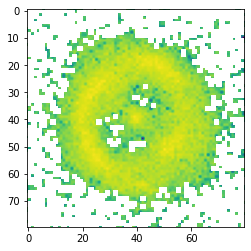

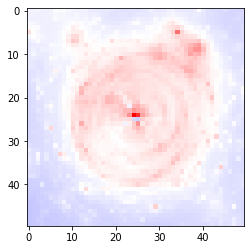

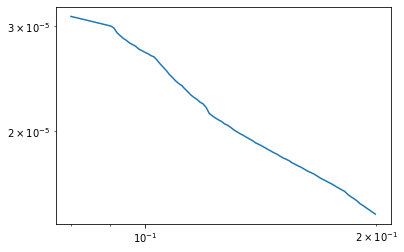

In [26]:
filename_image, filename_corr, filename_corr_statistics, filename_kappa_map = filenames(1, os.getcwd() + '/correlation_function_test_1')
lensed_image = np.loadtxt(filename_image)
plt.imshow(np.log10(lensed_image).reshape(80, 80))
plt.show()
kappa_map = np.loadtxt(filename_kappa_map)
plt.imshow(kappa_map.reshape(numPix_kappa_map,numPix_kappa_map) - np.mean(kappa_map), vmin=-0.1, vmax=0.1, cmap='bwr')
plt.show()
correlation_function = np.loadtxt(filename_corr)
r, x0_v1, x2_v1 = correlation_function[0:100], correlation_function[100:200], correlation_function[200:300]
plt.loglog(r, x0_v1)
plt.show()


In [27]:
seed = 1002 # date
filename_index = 1
output_path = os.getcwd() + '/correlation_function_test_2'
kwargs_observing = {}
kwargs_sample_redshifts = {}
kwargs_sample_macromodel = {}
kwargs_sample_source = {}
kwargs_sample_lens_light = {}
kwargs_sample_substructure = {'log_mlow': 6.0, 'log_mhigh': 10.0, 
                              'log10_sigma_sub_low': -2.5, 'log10_sigma_sub_high': -0.5, 
                              'LOS_norm_low': 0.5, 'LOS_norm_high': 2.0, 
                              'log10_rescale_mc_amp_min': 0.0, 'log10_rescale_mc_amp_max': 0.0,
                              # make low-mass halos more concentrated
                              'rescale_mc_slope_min': -0.5, 'rescale_mc_slope_max': -0.5, 
                             }
single_iteration(output_path, filename_index, kwargs_observing, kwargs_sample_redshifts, kwargs_sample_macromodel, kwargs_sample_source, 
          kwargs_sample_lens_light, kwargs_sample_substructure, save_correlation_function=True, 
                 save_kappa_map=True, numPix_kappa_map=numPix_kappa_map, seed=seed)

{'custom_class': <class '__main__.RescaledDiemerJoyce'>, 'rescale_amp': 1.0, 'rescale_slope': -0.5}
It took 14.29 seconds to compute the correlation map


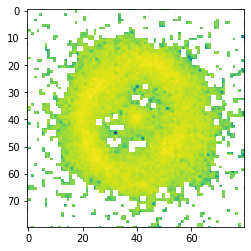

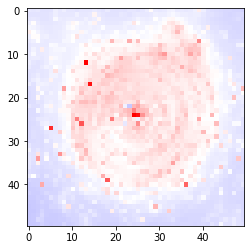

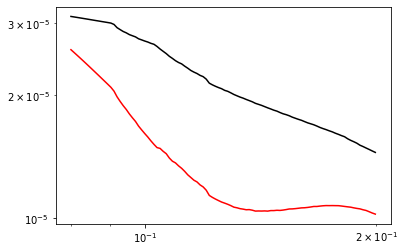

In [28]:
filename_image, filename_corr, filename_corr_statistics, filename_kappa_map = filenames(1, os.getcwd() + '/correlation_function_test_2')
lensed_image = np.loadtxt(filename_image)
plt.imshow(np.log10(lensed_image).reshape(80, 80))
plt.show()
kappa_map = np.loadtxt(filename_kappa_map)
plt.imshow(kappa_map.reshape(numPix_kappa_map,numPix_kappa_map) - np.mean(kappa_map), vmin=-0.1, vmax=0.1, cmap='bwr')
plt.show()
correlation_function = np.loadtxt(filename_corr)
r, x0_v2, x2_v2 = correlation_function[0:100], correlation_function[100:200], correlation_function[200:300]
plt.loglog(r, x0_v1, color='k')
plt.loglog(r, x0_v2, color='r')
plt.show()

In [29]:
seed = None
filename_index = 2
output_path = os.getcwd() + '/correlation_function_test_1'
kwargs_observing = {}
kwargs_sample_redshifts = {}
kwargs_sample_macromodel = {}
kwargs_sample_source = {}
kwargs_sample_lens_light = {}
kwargs_sample_substructure = {'log_mlow': 6.0, 'log_mhigh': 10.0, 
                              'log10_sigma_sub_low': -2.5, 'log10_sigma_sub_high': -0.5, 
                              'LOS_norm_low': 0.5, 'LOS_norm_high': 2.0, 
                              # turns off rescaling of MC relation
                              'log10_rescale_mc_amp_min': 0.0, 'log10_rescale_mc_amp_max': 0.0, 
                              # turns off rescaling of slope
                              'rescale_mc_slope_min': 0.0, 'rescale_mc_slope_max': 0.0, 
                             }
single_iteration(output_path, filename_index, kwargs_observing, kwargs_sample_redshifts, kwargs_sample_macromodel, kwargs_sample_source, 
          kwargs_sample_lens_light, kwargs_sample_substructure, save_correlation_function=True, 
                 save_kappa_map=True, numPix_kappa_map=numPix_kappa_map, seed=seed)

{'custom_class': <class '__main__.RescaledDiemerJoyce'>, 'rescale_amp': 1.0, 'rescale_slope': 0.0}
It took 14.37 seconds to compute the correlation map


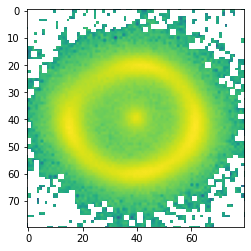

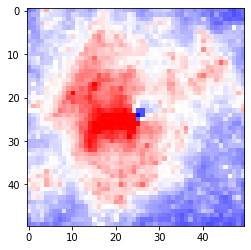

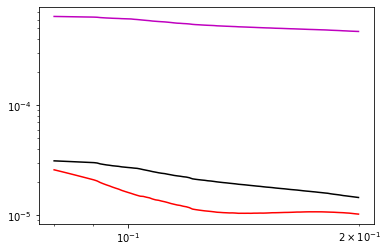

In [30]:
filename_image, filename_corr, filename_corr_statistics, filename_kappa_map = filenames(2, os.getcwd() + '/correlation_function_test_1')
lensed_image = np.loadtxt(filename_image)
plt.imshow(np.log10(lensed_image).reshape(80, 80))
plt.show()
kappa_map = np.loadtxt(filename_kappa_map)
plt.imshow(kappa_map.reshape(numPix_kappa_map,numPix_kappa_map) - np.mean(kappa_map), vmin=-0.1, vmax=0.1, cmap='bwr')
plt.show()
correlation_function = np.loadtxt(filename_corr)
r, x0_v3, x2_v3 = correlation_function[0:100], correlation_function[100:200], correlation_function[200:300]
plt.loglog(r, x0_v1, color='k')
plt.loglog(r, x0_v2, color='r')
plt.loglog(r, x0_v3, color='m')
plt.show()

### Now repeat the calculation from the first cell, and check the data gets appended to the files correctly

In [32]:
seed = 1003 # date
filename_index = 1
output_path = os.getcwd() + '/correlation_function_test_1'
kwargs_observing = {}
kwargs_sample_redshifts = {}
kwargs_sample_macromodel = {}
kwargs_sample_source = {}
kwargs_sample_lens_light = {}
kwargs_sample_substructure = {'log_mlow': 6.0, 'log_mhigh': 10.0, 
                              'log10_sigma_sub_low': -2.5, 'log10_sigma_sub_high': -0.5, 
                              'LOS_norm_low': 0.5, 'LOS_norm_high': 2.0, 
                              'log10_rescale_mc_amp_min': 0.0, 'log10_rescale_mc_amp_max': 0.0, 
                              # turns off rescaling of MC relation
                              'rescale_mc_slope_min': 0.0, 'rescale_mc_slope_max': 0.0, 
                              # turns off rescaling of slope
                             }
numPix_kappa_map = 50
single_iteration(output_path, filename_index, kwargs_observing, kwargs_sample_redshifts, kwargs_sample_macromodel, kwargs_sample_source, 
          kwargs_sample_lens_light, kwargs_sample_substructure, save_correlation_function=True, 
                 save_kappa_map=True, numPix_kappa_map=numPix_kappa_map, seed=seed)

{'custom_class': <class '__main__.RescaledDiemerJoyce'>, 'rescale_amp': 1.0, 'rescale_slope': 0.0}
It took 14.31 seconds to compute the correlation map


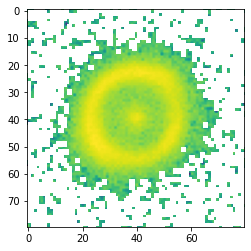

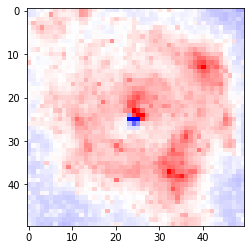

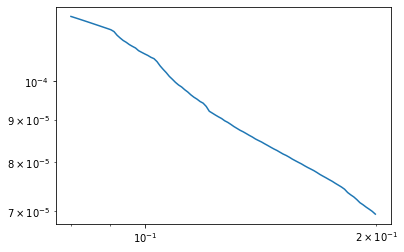

In [40]:
filename_image, filename_corr, filename_corr_statistics, filename_kappa_map = filenames(1, os.getcwd() + '/correlation_function_test_1')
lensed_image = np.loadtxt(filename_image)
plt.imshow(np.log10(lensed_image[1]).reshape(80, 80))
plt.show()
kappa_map = np.loadtxt(filename_kappa_map)
plt.imshow(kappa_map[1].reshape(numPix_kappa_map,numPix_kappa_map) - np.mean(kappa_map), vmin=-0.1, vmax=0.1, cmap='bwr')
plt.show()
correlation_function = np.loadtxt(filename_corr)[1]
r, x0_v1, x2_v1 = correlation_function[0:100], correlation_function[100:200], correlation_function[200:300]
plt.loglog(r, x0_v1)
plt.show()


In [ ]:
### Now repeat the calculation from the first cell with the same seed, verify outputs are the same 

In [41]:
seed = 1002 # date
filename_index = 1
output_path = os.getcwd() + '/correlation_function_test_1'
kwargs_observing = {}
kwargs_sample_redshifts = {}
kwargs_sample_macromodel = {}
kwargs_sample_source = {}
kwargs_sample_lens_light = {}
kwargs_sample_substructure = {'log_mlow': 6.0, 'log_mhigh': 10.0, 
                              'log10_sigma_sub_low': -2.5, 'log10_sigma_sub_high': -0.5, 
                              'LOS_norm_low': 0.5, 'LOS_norm_high': 2.0, 
                              'log10_rescale_mc_amp_min': 0.0, 'log10_rescale_mc_amp_max': 0.0, 
                              # turns off rescaling of MC relation
                              'rescale_mc_slope_min': 0.0, 'rescale_mc_slope_max': 0.0, 
                              # turns off rescaling of slope
                             }
numPix_kappa_map = 50
single_iteration(output_path, filename_index, kwargs_observing, kwargs_sample_redshifts, kwargs_sample_macromodel, kwargs_sample_source, 
          kwargs_sample_lens_light, kwargs_sample_substructure, save_correlation_function=True, 
                 save_kappa_map=True, numPix_kappa_map=numPix_kappa_map, seed=seed)

{'custom_class': <class '__main__.RescaledDiemerJoyce'>, 'rescale_amp': 1.0, 'rescale_slope': 0.0}
It took 14.32 seconds to compute the correlation map


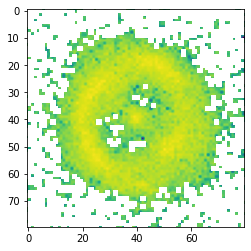

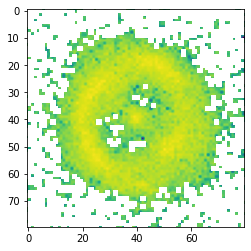

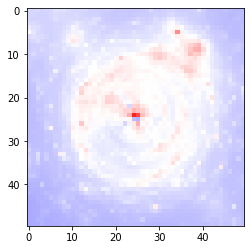

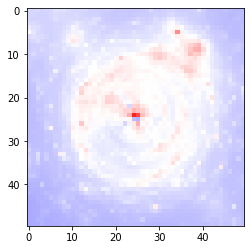

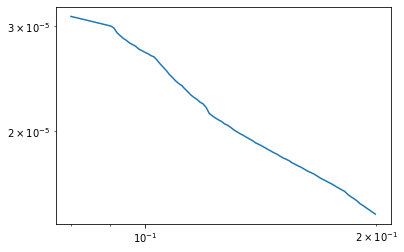

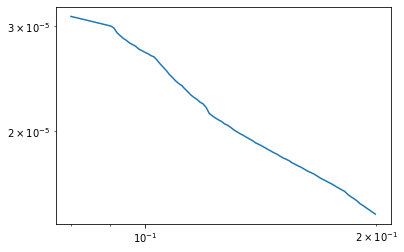

In [47]:
filename_image, filename_corr, filename_corr_statistics, filename_kappa_map = filenames(1, os.getcwd() + '/correlation_function_test_1')

lensed_image_1 = np.loadtxt(filename_image)[0]
plt.imshow(np.log10(lensed_image_1).reshape(80, 80))
plt.show()

lensed_image_2 = np.loadtxt(filename_image)[2]
plt.imshow(np.log10(lensed_image_2).reshape(80, 80))
plt.show()
assert np.allclose(lensed_image_1, lensed_image_2)

kappa_map_1 = np.loadtxt(filename_kappa_map)[0]
plt.imshow(kappa_map_1.reshape(numPix_kappa_map,numPix_kappa_map) - np.mean(kappa_map), vmin=-0.1, vmax=0.1, cmap='bwr')
plt.show()

kappa_map_2 = np.loadtxt(filename_kappa_map)[2]
plt.imshow(kappa_map_2.reshape(numPix_kappa_map,numPix_kappa_map) - np.mean(kappa_map), vmin=-0.1, vmax=0.1, cmap='bwr')
plt.show()
assert np.allclose(kappa_map_1, kappa_map_2)

correlation_function_1 = np.loadtxt(filename_corr)[0]
r, x0_v1, x2_v1 = correlation_function_1[0:100], correlation_function_1[100:200], correlation_function_1[200:300]
plt.loglog(r, x0_v1)
plt.show()

correlation_function_2 = np.loadtxt(filename_corr)[2]
r, x0_v1, x2_v1 = correlation_function_2[0:100], correlation_function_2[100:200], correlation_function_2[200:300]
plt.loglog(r, x0_v1)
plt.show()
assert np.allclose(correlation_function_1, correlation_function_2)
